In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import collections
from tqdm import tqdm, tqdm_notebook

# PyTorch Packages
import torch.nn as nn
from torch.autograd import Variable as V
import torch
from torch.utils.data import DataLoader

# SKLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score)
from sklearn.metrics import accuracy_score, precision_score

# Plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.palettes import Set3_12
from bokeh.transform import jitter

In [2]:
output_notebook()

Loading BokehJS ...

## Approach

The general approach to this notebook is based on this awesome [post.](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd) However, this implementation utilizes Pytorch as well as several modifications the architecture and input data.
This notebook investigates using an autoencoder for anomaly and fraud detection. Autoencoders aren't new to machine learning, but they are not as prolific as some of the newer techniques in deep learning. An autoencoder's goal is to compress an input and then reconstruct the original input from the compressed data.
![deep_autoencoder.png](https://deeplearning4j.org/img/deep_autoencoder.png)

It is an unsupervised algorithm since the target variable is the input. There are many use cases and interesting applications of autoencoders which can be seen [here](https://towardsdatascience.com/autoencoders-bits-and-bytes-of-deep-learning-eaba376f23ad).


In the case of detecting fraud, the approach is to build a model that will learn the characteristics of a normal transaction by training the model on non-fraudulent data points only. The idea is to get the model as accurate as possible at recreating normal transaction from the filtered data set. Once you have a model that can recreate normal transactions with a given amount of error, you then use the model to predict a set of data that has both normal and fraudulent transaction. If everything goes well, you will have a model that given a normal transaction will predict the original inputs with a small margin of error and a much larger error for transactions that are fraudulent.

In [3]:
df = pd.read_csv('creditcard.csv')

Since the *time* column comes in as seconds from the start of the 2 day period. I first normalized the time to a normal 24 hour clock as well as the time of every transaction and the amount to see if there is any pattern in the timing of fraudulent charges. For this notebook I will be using a mix of Bokeh and Seaborn for visualization.

In [4]:
df['TimeNorm'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24.)

In [5]:
def format_plot(p, x_label, y_label):
    p.grid.grid_line_color = None
    p.background_fill_color = "whitesmoke"
    p.axis.minor_tick_line_color = None
    p.title.align = 'center'
    p.title.text_font_size = "18px"
    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.xaxis.axis_label_text_font_size = "14px"
    p.yaxis.axis_label_text_font_size = "14px"
    p.yaxis.axis_line_color = None
    p.yaxis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "12px"
    return p

In [6]:
# Get only fraud transactions
fraud_df = df[df['Class'] == 1]
f_source = ColumnDataSource(data = dict(x = fraud_df['TimeNorm'].values,
                                    y = fraud_df['Amount'].values))
# get only normal transactions
non_fraud_df = df[df['Class'] == 0]
# Limit amount of data in plot
sample_non_fraud = df.sample(frac=0.01, replace=False)
norm_source = ColumnDataSource(data = dict(x = sample_non_fraud['TimeNorm'].values,
                                    y = sample_non_fraud['Amount'].values))
# create Bokeh figure
p = figure(plot_width = 800, 
           toolbar_location = None, 
           title = 'Transactions by Time and Amount')

# plot Normal Transactions
p.circle(x=jitter('x', width=0.9, range=p.x_range), 
         y='y', color = Set3_12[4], 
         fill_alpha = 0.1, 
         source = norm_source)

# plot fraud transactions
p.circle(x=jitter('x', width=0.9,range=p.x_range), 
         y='y', color = Set3_12[3], 
         fill_alpha = 0.7, 
         source = f_source)

#function to format plot
p = format_plot(p, "Time", "Amount")

p.yaxis[0].formatter = NumeralTickFormatter(format="$0,0")

show(p)

In [7]:
df.loc[df['Class'] == 1, 'Amount'].max()

2125.8699999999999

From the chart above, it appears that there is no clear time window when fraud occurs more frequently. You can also see that all fraudulent charges fall below $2,126. While there may not be a lot of information gained by a visual inspection of time, I decided to leave it in the dataset as there may be some interactions with other variables that help detect these charges.

### Data Normalization

Next I normalized the time and amount variables to ease with model learning,and split the data into a training and testing dataset. 

In [8]:
scl = StandardScaler()
df['TimeNorm'] = scl.fit_transform(df['TimeNorm'].values.reshape(-1,1))
scl = StandardScaler()
df['NormAmt'] = scl.fit_transform(df['Amount'].values.reshape(-1,1))

In [9]:
df = df.drop(['Time', 'Amount'], axis = 1)

In [10]:
x_train, x_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [11]:
x_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,TimeNorm,NormAmt
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,0,0.300989,-0.313289
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,0,-0.822459,-0.169717
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,0,0.621974,-0.305292
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0,-1.785414,0.116306
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,0,1.424436,-0.250239


Since we are training an autoencoder that will learn the features of a normal transaction, we filter the training set to remove all transactions that were fraudulent from the training set . We leave the test set as is, containing both types of transactions.

In [12]:
x_train = x_train[x_train['Class'] == 0]
x_train = x_train.drop('Class', axis = 1)

y_test = x_test['Class'].values
x_test = x_test.drop('Class', axis = 1)
x_test = x_test.values
x_train = x_train.values

x_train.shape, x_test.shape

((227451, 30), (56962, 30))

Next I transformed the numpy arrays as a PyTorch Float Tensor and loaded them into a DataLoader object. The dataloader is a generator that feeds the data to the training loop at the specified batch size.

In [13]:
xt = torch.FloatTensor(x_train)
xtr = torch.FloatTensor(x_test)
xdl = DataLoader(xt,batch_size = 1000)
tdl = DataLoader(xtr, batch_size = 1000)

### Autoencoder Model

The architecture of the autoencoder consist of 4 fully connected layers starting at an input size of 30 (30 variables) reducing down to 10 and then decoding back up to 30.

In [14]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30,20)
        self.lin2 = nn.Linear(20,10)
        self.lin7 = nn.Linear(10,20)
        self.lin8 = nn.Linear(20,30)
        
        self.drop2 = nn.Dropout(0.05)
        
        self.lin1.weight.data.uniform_(-2,2)
        self.lin2.weight.data.uniform_(-2,2)
        self.lin7.weight.data.uniform_(-2,2)
        self.lin8.weight.data.uniform_(-2,2)

    def forward(self, data):
        x = torch.tanh(self.lin1(data))
        x = self.drop2(torch.tanh(self.lin2(x)))
        x = torch.tanh(self.lin7(x))
        x = self.lin8(x)
        
        return (x)

This function utilizes the model's loss function to calculate the loss for the validation test set. In this instance of using an autoencoder for anomaly detection, the validation score doesn't mean much since it will have both fraud and non-fraud scores. What we really care about is having the model learn as much as it can about the features of a normal transaction.

In [15]:
def score(x):
    y_pred = model(V(x))
    x1 = V(x)
    return loss(y_pred,x1).item()

Next is the training loop. This function takes in the number of epochs you want to run as well as a model_loss variable that is used to keep the history (model and validation loss) at each epoch. 
This is a fairly standard PyTorch training loop, except that instead of taking in a X and a Y variable, it takes in X from the dataloader, gets the prediction from the model, and determines the loss between the original X and the model prediction. It then goes on to change the gradients through back propagation based on the determined loss.

In [16]:
# Utilize a named tuple to keep track of scores at each epoch
model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])

In [17]:
def train(epochs, model, model_loss):
    try:c = model_loss.epoch[-1]
    except: c = 0
    for epoch in tqdm_notebook(range(epochs),position=0, total = epochs):
        losses=[]
        dl = iter(xdl)
        for t in range(len(dl)):
            # Forward pass: compute predicted y and loss by passing x to the model.
            xt = next(dl)
            y_pred = model(V(xt))
            
            l = loss(y_pred,V(xt))
            losses.append(l)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            l.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
    
        val_dl = iter(tdl)
        val_scores = [score(next(val_dl)) for i in range(len(val_dl))]
        
        model_loss.epoch.append(c+epoch)
        model_loss.loss.append(l.item())
        model_loss.val_loss.append(np.mean(val_scores))
        print(f'Epoch: {epoch}   Loss: {l.item():.4f}    Val_Loss: {np.mean(val_scores):.4f}')

### Model Training

With the Pytorch structure set up we can now train the model.

In [18]:
model = Net1()
loss=nn.MSELoss()
learning_rate = 1e-2
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
train(model = model, epochs = 30,model_loss= model_loss)

A Jupyter Widget

Epoch: 0   Loss: 0.9356    Val_Loss: 1.0663
Epoch: 1   Loss: 0.8583    Val_Loss: 0.9721
Epoch: 2   Loss: 0.8018    Val_Loss: 0.9127
Epoch: 3   Loss: 0.7679    Val_Loss: 0.8671
Epoch: 4   Loss: 0.7092    Val_Loss: 0.8105
Epoch: 5   Loss: 0.6552    Val_Loss: 0.7569
Epoch: 6   Loss: 0.6177    Val_Loss: 0.7215
Epoch: 7   Loss: 0.5952    Val_Loss: 0.6963
Epoch: 8   Loss: 0.5572    Val_Loss: 0.6741
Epoch: 9   Loss: 0.5402    Val_Loss: 0.6528
Epoch: 10   Loss: 0.5147    Val_Loss: 0.6260
Epoch: 11   Loss: 0.4997    Val_Loss: 0.6007
Epoch: 12   Loss: 0.4681    Val_Loss: 0.5765
Epoch: 13   Loss: 0.4362    Val_Loss: 0.5550
Epoch: 14   Loss: 0.4251    Val_Loss: 0.5383
Epoch: 15   Loss: 0.4160    Val_Loss: 0.5238
Epoch: 16   Loss: 0.4190    Val_Loss: 0.5126
Epoch: 17   Loss: 0.3856    Val_Loss: 0.5009
Epoch: 18   Loss: 0.3782    Val_Loss: 0.4847
Epoch: 19   Loss: 0.3705    Val_Loss: 0.4679
Epoch: 20   Loss: 0.3656    Val_Loss: 0.4581
Epoch: 21   Loss: 0.3432    Val_Loss: 0.4470
Epoch: 22   Loss: 0.

### Training Evaluation

In [20]:
# Define a plot source
source = ColumnDataSource(data=dict(
    x=model_loss.epoch,
    loss=model_loss.loss,
    val_loss = model_loss.val_loss
))

p = figure(plot_height = 500, 
           plot_width = 800,
           toolbar_location = None, 
           title = "Model L1 Loss")

ml = p.line(x = "x", y = "loss", 
           color=Set3_12[4], 
           line_width = 2, 
           legend = "Training Loss", 
           source=source)

p.line(x = "x", y = "val_loss", 
       color=Set3_12[5], 
       line_width = 2, 
       legend = "Validation Loss",
       source=source)


tips = [
    ("Epoch","@x"),
    ("Model Loss","@loss{0.000}"),
    ("Val Loss","@val_loss{0.000}")
]
p.add_tools(HoverTool(tooltips=tips, 
                      renderers= [ml], 
                      mode='vline'))


p = format_plot(p, 'Epoch', 'Loss')

show(p);

From the chart above you can see that the the model loss is still going down. It is likely that there could have been additional performance gains from running a few more epochs to allow the loss to flatten out.

Now it's time to calculate the reconstruction error on the test set to see how well it predicts normal transactions vs fraud.


In [21]:
print(model)

Net1(
  (lin1): Linear(in_features=30, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (lin7): Linear(in_features=10, out_features=20, bias=True)
  (lin8): Linear(in_features=20, out_features=30, bias=True)
  (drop2): Dropout(p=0.05)
)


In [22]:
model.state_dict()

OrderedDict([('lin1.weight',
              tensor([[-0.0741, -0.0129, -0.0671, -0.1336,  0.3242,  0.2949, -0.2316,  0.2098,
                       -0.0187, -0.1505,  0.1697, -0.1389, -0.0586, -0.1894, -0.0224, -0.2174,
                       -0.2950, -0.0801,  0.0601,  0.0421,  0.0739,  0.0681,  0.0863, -0.0767,
                       -0.1393, -0.0371, -0.0342, -0.1398, -0.0263,  0.1225],
                      [ 0.8875, -0.3734, -0.0570, -0.0401, -0.8162,  0.2939,  0.8418,  1.5208,
                       -0.7356, -0.8945,  0.6972, -0.4183,  0.3011, -0.7043,  0.2630, -0.5396,
                       -0.9999, -0.4325,  0.2416,  0.2252,  0.5153, -0.2011, -0.7732,  0.0610,
                       -0.2132, -0.0843, -0.2315,  1.0471,  0.3536, -0.9404],
                      [ 0.2057,  0.0279,  0.3294, -0.0041,  0.2134,  0.0356, -0.0805, -0.1091,
                        0.1482,  0.2946, -0.2156,  0.3313,  0.0311,  0.3141,  0.1307,  0.2477,
                        0.6354,  0.1770,  0.1827, -0.29

In [23]:
model.state_dict()['lin1.weight']

tensor([[-0.0741, -0.0129, -0.0671, -0.1336,  0.3242,  0.2949, -0.2316,  0.2098,
         -0.0187, -0.1505,  0.1697, -0.1389, -0.0586, -0.1894, -0.0224, -0.2174,
         -0.2950, -0.0801,  0.0601,  0.0421,  0.0739,  0.0681,  0.0863, -0.0767,
         -0.1393, -0.0371, -0.0342, -0.1398, -0.0263,  0.1225],
        [ 0.8875, -0.3734, -0.0570, -0.0401, -0.8162,  0.2939,  0.8418,  1.5208,
         -0.7356, -0.8945,  0.6972, -0.4183,  0.3011, -0.7043,  0.2630, -0.5396,
         -0.9999, -0.4325,  0.2416,  0.2252,  0.5153, -0.2011, -0.7732,  0.0610,
         -0.2132, -0.0843, -0.2315,  1.0471,  0.3536, -0.9404],
        [ 0.2057,  0.0279,  0.3294, -0.0041,  0.2134,  0.0356, -0.0805, -0.1091,
          0.1482,  0.2946, -0.2156,  0.3313,  0.0311,  0.3141,  0.1307,  0.2477,
          0.6354,  0.1770,  0.1827, -0.2913, -0.0104,  0.0484,  0.1567, -0.0553,
          0.0234,  0.0047, -0.0892, -0.0705, -0.0733,  0.4505],
        [-0.7546,  0.1878, -0.4326,  0.9684,  0.3054, -0.0247,  0.3498, -0.3124

### Predictions

Next I utilized the trained model to make predictions on the test set which. unlike the training set, has fraudulent transactions. I fed in the test dataloader to the model to get predictions,and then calculated the reconstruction error, which is the amount of error between the original input and the model predictions against the test set. The error for each row will be used to determine if each transaction is normal or fraud.

In [24]:
# Iterate through the dataloader and get predictions for each batch of the test set.
p = iter(tdl)
preds = np.vstack([model(V(next(p))).cpu().data.numpy() for i in range(len(p))])

# Create a pandas DF that shows the Autoencoder MSE vs True Labels
error = np.mean(np.power((x_test - preds),2), axis = 1)
error_df = pd.DataFrame(data = {'error':error,'true':y_test})

error_df.groupby('true')['error'].describe().reset_index()

,true,count,mean,std,min,25%,50%,75%,max
0,0,56864.0,0.344839,1.400083,0.009767,0.128839,0.201438,0.327531,111.530727
1,1,98.0,25.845565,36.642453,0.144094,4.645122,9.806507,44.367290,203.054190


By stacking the error on the test set next to the actual target value (1,0) for ease of use I created a pandas DataFrame and grouped the data by the two types of transactions. From the summary table above we can see that the statistics for the two groups look quite different. However we have to evaluate further to see if they are in fact different enough for accurate final predictions. I started by looking at the ROC AUC.

In [25]:
fpr, tpr, thresholds = roc_curve(error_df.true, error_df.error)
roc_auc = auc(fpr, tpr)

source = ColumnDataSource(data=dict(
    fpr = fpr,
    tpr = tpr,
    x = np.linspace(0,1,len(fpr)),
    y = np.linspace(0,1,len(fpr))
))

p = figure(plot_height = 500, plot_width = 500,
           toolbar_location = None, 
           title = "Receiver Operating Characteristic")

j = p.line(x = "x", y = "y", 
           color=Set3_12[3], 
           line_width = 2, 
           line_dash = 'dashed', 
           source=source)

k = p.line(x = "fpr", y = "tpr", 
           color=Set3_12[4], 
           line_width = 2, 
           legend = f'AUC = {roc_auc:0.4f}',
           source=source)

tips= [
    ("False-Pos", "@fpr{00.0%}"),
    ("True-Pos", "@tpr{00.0%}"),
    ]
p.add_tools(HoverTool(tooltips=tips, renderers=[k], mode='vline'))

p = format_plot(p, 'False Positive Rate', 'True Positive Rate')
p.legend.location = 'bottom_right'

show(p);

### Model Perfomance

ROC AUC plots the False Positive Rate against the True Positive rate. The dashed red line represents a random guess of a 50/50 chance of predicting the correct outcome. Ideally the ROC line would fit perfectly in the upper left hand corner which would represent a perfect model. While the ROC AUC is generally a good thing to use to check model performance, it only looks at 2 of the possible 4 outcomes of binary classification. False Negatives and True negatives are not directly observed in this plot. To get the rest of the story it is necessary to look at the confusion matrix. 

When performing binary classification there are 4 types of outcomes:

![confusion_matrix_1.png](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

In the case of this dataset:
* ***True Positive:*** The number of normal transactions did we correctly predict as normal
* ***False Negatives:*** The number of normal transactions that the model incorrectly classifies as fraud
* ***False Positives:*** The number of fraudulent transactions the model incorrectly classifies as normal
* ***True Negatives:*** The number of fraudlent transactions the model accurately classifies as fraud

Since our predictions are based on the error between the original and predicted values of the input, it is necessary to find a cut-off point in the error where anything above the threshold is considered fraud, and anything below is considered to be a normal transaction. To start I decided to set the threshold as the sum of the mean and standard deviation of the error of the normal transactions.

In [26]:
temp_df = error_df[error_df['true'] == 0]
threshold = temp_df['error'].mean() + temp_df['error'].std()
print(f'Threshold: {threshold:.3f}')

Threshold: 1.745


In [27]:
y_pred = [1 if e > threshold else 0 for e in error_df.error.values]
print(classification_report(error_df.true.values,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.88      0.18        98

   micro avg       0.99      0.99      0.99     56962
   macro avg       0.55      0.93      0.59     56962
weighted avg       1.00      0.99      0.99     56962



Above is the classification report, but I found these metrics to be a bit deceiving and hard to conceptualize. I found that in the case of this unbalanced dataset it is easier to understand by looking at the actual values for number of fraudulent transactions missed as well as the number of normal transactions that were misclassified in the confusion matrix.

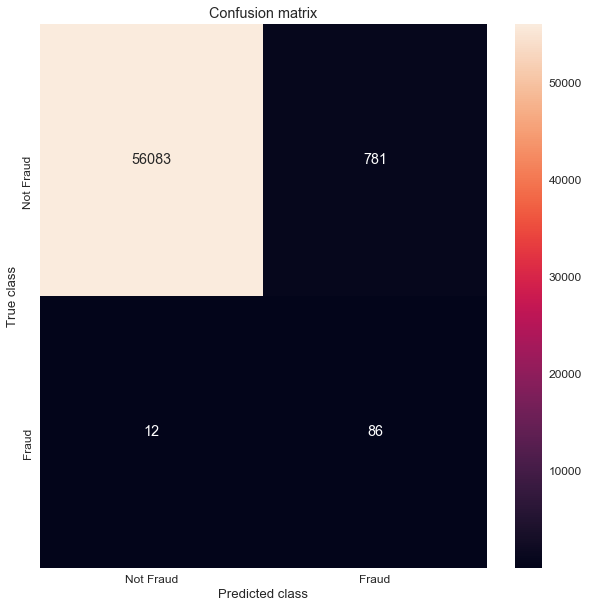

In [28]:
conf_matrix = confusion_matrix(error_df.true, y_pred)

sns.set(font_scale = 1.2)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

At first look, the model seems to catch all but about 15% of the fraudulent transactions, but at that threshold the model incorrectly identifies around
4000 normal transactions as fraud (False Negatives).

This is where the benefit of having a threshold pays off. It allows the flexibility of determining the amount of normal transactions you are willing to accept in order to catch the targeted amount of Fraud. The False Negatives and False Positives exhibit inverse behavior; as the amount of missed fraudulent transactions decreases, the normal transactions that are incorrectly predicted as fraud increases.

Next I iterated through a range of thresholds and plotted the confusion matrix at each threshold to get a better idea of what the decision space looks like.

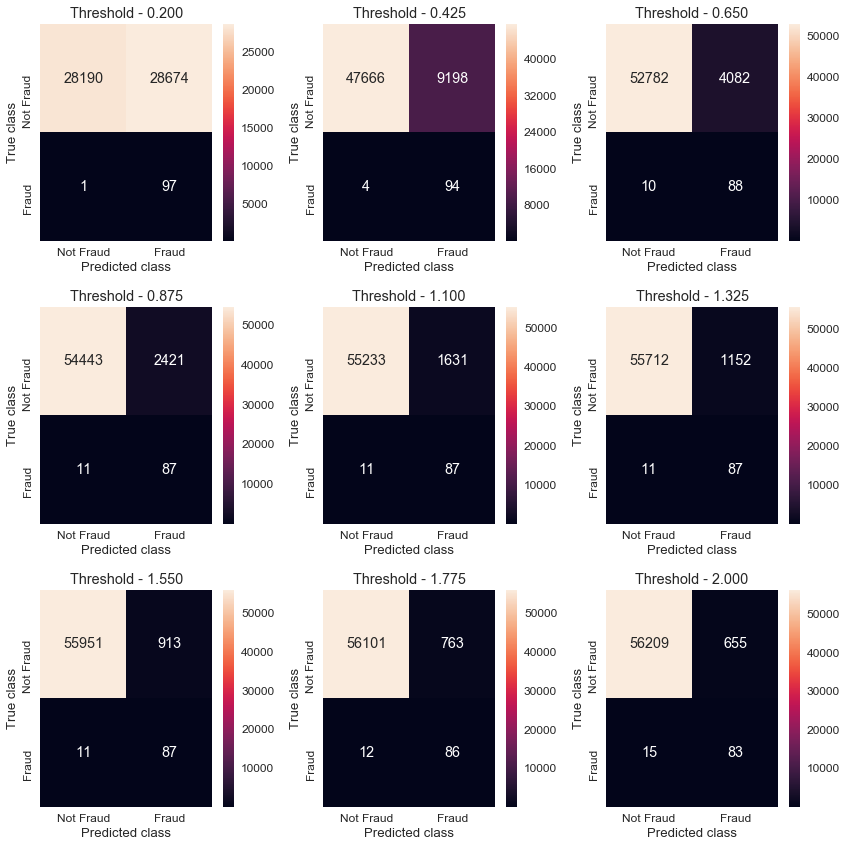

In [29]:
plt.figure(figsize=(12, 12))
m = []
for thresh in np.linspace(0.2,2,9):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf_matrix = confusion_matrix(error_df.true, y_pred)
    m.append((conf_matrix,thresh))
    
count = 0
for i in range(3):
    for j in range(3):
        plt.subplot2grid((3, 3), (i, j))
        sns.heatmap(m[count][0], xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'], annot=True, fmt="d");
        plt.title(f"Threshold - {m[count][1]:.3f}")
        plt.ylabel('True class')
        plt.xlabel('Predicted class')
        plt.tight_layout()
        count += 1
plt.show()

In [30]:
thr = []
tp = []
fn = []
fp = []
tn = []
for thresh in np.linspace(0.2,3,200):
    y_pred = [1 if e > thresh else 0 for e in error_df.error.values]
    conf = confusion_matrix(error_df.true, y_pred)
    tp.append(conf[0][0])
    fp.append(conf[0][1])
    fn.append(conf[1][0])
    tn.append(conf[1][1])
    thr.append(thresh)

conf_df = pd.DataFrame(data = {'fp':fp,'fn':fn,'threshold':thr})
cdf = conf_df.drop_duplicates(subset='fn',keep='last')
print(cdf)

        fp  fn  threshold
8    15335   1   0.312563
9    14274   3   0.326633
17    8677   4   0.439196
20    7381   5   0.481407
21    7018   6   0.495477
25    5690   7   0.551759
27    5125   8   0.579899
30    4464   9   0.622111
32    4080  10   0.650251
102    851  11   1.635176
116    734  12   1.832161
117    723  14   1.846231
136    611  15   2.113568
138    600  16   2.141709
188    437  17   2.845226
196    409  18   2.957789
199    400  19   3.000000


In [31]:
xx = [str(x) for x in cdf['fn'].values]
source = ColumnDataSource(data=dict(
    fn = xx,
    fp = cdf['fp'].values,
))

p = figure(plot_width = 800,
           toolbar_location = None, x_range = xx,
           title = "False Negative vs False Positive")

p.vbar(x = "fn", top = "fp", width = 0.9,
           color=Set3_12[3],  
           source=source)

p = format_plot(p, 'False Negatives', 'False Positive')

show(p);

In the plot above you can see the trade-space for a given reconstruction error threshold. There is a large dropoff after 2 False Negatives. Ideally this plot would be in percentages to show overall model performance, since these numbers would change depending on your test set size. However actual number of fraudulent transactions is a bit more intuitive.

### Conclusion and Further Work

Since the data we were given represents the principal components, it is difficult to fully understand the value of each of the model inputs. In this notebook I did not attempt to do any feature engineering or general dimensional reduction (although the autoencoder does) to try to improve the model.

In general the model performs well, but there is still a small number of fraudulent transactions that can't be cleanly separated from normal transactions. The model provides a decision space to do tradeoff analysis and determine the best threshold given how much a fraudulent transaction costs the business vs how much it costs to incorrectly label normal transactions (which is difficult to quantify).

Next, I would like to look into ensembling this with other models as well as taking the weights of the pre-trained autoencoder and using additonal layers to perform the final binary classification.

Thanks for reading.